In [1]:
# 安裝必要的套件（如果尚未安裝）
# 可以取消以下註解來安裝
# !pip install transformers
# !pip install torch
# !pip install scikit-learn
# !pip install tqdm
# !pip install xgboost
# !pip install pandas
# !pip install numpy
# !pip install matplotlib

import os
import re
import numpy as np
import pandas as pd
from datetime import datetime

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from tqdm import tqdm
import xgboost as xgb

print("所有套件匯入完成。")


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


所有套件匯入完成。


In [2]:
def clean_text(txt: str) -> str:
    """簡單文本清理，去除多餘空白和雜訊。"""
    if not isinstance(txt, str):
        return ""
    txt = re.sub(r'\s+', ' ', txt)
    return txt.strip()

def parse_cnbc_time(t):
    """解析 CNBC 的時間格式: '7:51 PM ET Fri, 17 July 2020'"""
    if not isinstance(t, str):
        return None
    match = re.search(r'(\d{1,2}\s+\w+\s+\d{4})', t)
    if match:
        date_str = match.group(1)
        try:
            dt = datetime.strptime(date_str, '%d %B %Y')
            return dt.strftime('%Y-%m-%d')
        except:
            return None
    return None

def parse_guardian_time(t):
    """解析 Guardian 的時間格式: '18-Jul-20'"""
    if not isinstance(t, str):
        return None
    try:
        dt = datetime.strptime(t.strip(), '%d-%b-%y')
        return dt.strftime('%Y-%m-%d')
    except:
        return None

def parse_reuters_time(t):
    """解析 Reuters 的時間格式: 'Jul 18 2020'"""
    if not isinstance(t, str):
        return None
    try:
        dt = datetime.strptime(t.strip(), '%b %d %Y')
        return dt.strftime('%Y-%m-%d')
    except:
        return None


In [3]:
def load_cnbc(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')
    print(f"CNBC 原始欄位: {df.columns.tolist()}")
    expected_cols = ['Headlines', 'Time', 'Description']
    for col in expected_cols:
        if col not in df.columns:
            print(f"警告: CNBC CSV 缺少欄位 '{col}'")
    df['headline'] = df['Headlines'].fillna("").apply(clean_text)
    df['article_content'] = df['Description'].fillna("").apply(clean_text)
    df['date'] = df['Time'].apply(parse_cnbc_time)
    df = df[['date', 'headline', 'article_content']].dropna(subset=['date', 'headline'])
    df['source'] = 'CNBC'
    return df

def load_guardian(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')
    print(f"Guardian 原始欄位: {df.columns.tolist()}")
    expected_cols = ['Time', 'Headlines']
    for col in expected_cols:
        if col not in df.columns:
            print(f"警告: Guardian CSV 缺少欄位 '{col}'")
    df['headline'] = df['Headlines'].fillna("").apply(clean_text)
    df['article_content'] = ""  # Guardian 無 Description
    df['date'] = df['Time'].apply(parse_guardian_time)
    df = df[['date', 'headline', 'article_content']].dropna(subset=['date', 'headline'])
    df['source'] = 'Guardian'
    return df

def load_reuters(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')
    print(f"Reuters 原始欄位: {df.columns.tolist()}")
    expected_cols = ['Headlines', 'Time', 'Description']
    for col in expected_cols:
        if col not in df.columns:
            print(f"警告: Reuters CSV 缺少欄位 '{col}'")
    df['headline'] = df['Headlines'].fillna("").apply(clean_text)
    df['article_content'] = df['Description'].fillna("").apply(clean_text)
    df['date'] = df['Time'].apply(parse_reuters_time)
    df = df[['date', 'headline', 'article_content']].dropna(subset=['date', 'headline'])
    df['source'] = 'Reuters'
    return df

def merge_news(cnbc_path, guardian_path, reuters_path) -> pd.DataFrame:
    df_cnbc     = load_cnbc(cnbc_path)
    df_guardian = load_guardian(guardian_path)
    df_reuters  = load_reuters(reuters_path)
    df_news = pd.concat([df_cnbc, df_guardian, df_reuters], ignore_index=True)
    df_news.dropna(subset=['date','headline'], inplace=True)
    df_news.sort_values('date', inplace=True)
    print(f"合併後新聞數量: {len(df_news)}")
    return df_news

# 使用範例路徑（請根據您的實際檔案路徑修改）
cnbc_csv     = r"C:\Users\morri\Desktop\IRTM-project\test\cnbc_headlines.csv"
guardian_csv = r"C:\Users\morri\Desktop\IRTM-project\test\guardian_headlines.csv"
reuters_csv  = r"C:\Users\morri\Desktop\IRTM-project\test\reuters_headlines.csv"

# 讀取並合併新聞資料
df_news = merge_news(cnbc_csv, guardian_csv, reuters_csv)
print(f"[News] total: {len(df_news)} rows from 3 sources.")


CNBC 原始欄位: ['Headlines', 'Time', 'Description']
Guardian 原始欄位: ['Time', 'Headlines']
Reuters 原始欄位: ['Headlines', 'Time', 'Description']
合併後新聞數量: 51795
[News] total: 51795 rows from 3 sources.


In [4]:
def setup_finbert_pipeline():
    """初始化 FinBERT pipeline"""
    tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
    device = 0 if torch.cuda.is_available() else -1
    finbert_pipeline = pipeline(
        "sentiment-analysis",
        model=model,
        tokenizer=tokenizer,
        device=device
    )
    return finbert_pipeline

# 初始化 FinBERT
finbert_pipe = setup_finbert_pipeline()
print("FinBERT pipeline 初始化完成。")


Device set to use cuda:0


FinBERT pipeline 初始化完成。


In [5]:
def batch_sentiment(text_list, pipeline_fn, batch_size=16, max_length=128):
    """
    手動分批，並使用 tqdm 進度條顯示處理進度。
    pipeline_fn: transformers pipeline
    text_list: 需要做情緒分析的文本列表
    """
    results = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Sentiment Analysis Batches"):
        batch_texts = text_list[i : i+batch_size]
        try:
            batch_out = pipeline_fn(
                batch_texts,
                truncation=True,
                max_length=max_length
            )
            for out in batch_out:
                label = out['label'].lower()
                score = out['score']
                if label == 'positive':
                    results.append(+score)
                elif label == 'negative':
                    results.append(-score)
                else:
                    results.append(0.0)
        except Exception as e:
            print(f"批次 {i//batch_size + 1} 解析錯誤: {e}")
            results.extend([0.0]*len(batch_texts))
    return results

def compute_daily_sentiment(df_news: pd.DataFrame, sentiment_pipeline, batch_size=16, max_length=128) -> pd.DataFrame:
    """
    對 headline & article_content 做批次情緒分析，顯示 tqdm 進度條，並彙整成每日平均 (mean_headline_sent, mean_content_sent)。
    """
    print("開始批次情緒分析 (FinBERT) ...")

    # headline
    headlines = df_news['headline'].tolist()
    print("-> 分析 Headline")
    headline_scores = batch_sentiment(headlines, sentiment_pipeline, batch_size=batch_size, max_length=max_length)

    # content
    contents = df_news['article_content'].tolist()
    print("-> 分析 Content")
    content_scores = batch_sentiment(contents, sentiment_pipeline, batch_size=batch_size, max_length=max_length)

    df_news['headline_sent'] = headline_scores
    df_news['content_sent']  = content_scores

    print("-> 彙整當日情緒...")
    daily_sentiment = (
        df_news
        .groupby('date')
        .agg({'headline_sent':'mean','content_sent':'mean'})
        .reset_index()
        .rename(columns={
            'headline_sent': 'mean_headline_sent',
            'content_sent': 'mean_content_sent'
        })
    )
    print("情緒分析完成。若出現負值，可能代表負面新聞居多。")
    return daily_sentiment

# 計算每日情緒分數
daily_sentiment_df = compute_daily_sentiment(df_news, finbert_pipe, batch_size=32, max_length=128)
daily_sentiment_df.to_csv("daily_sentiment.csv", index=False)
print("[Output] daily_sentiment.csv 已輸出.")


開始批次情緒分析 (FinBERT) ...
-> 分析 Headline


Sentiment Analysis Batches: 100%|██████████| 1619/1619 [08:10<00:00,  3.30it/s]


-> 分析 Content


Sentiment Analysis Batches: 100%|██████████| 1619/1619 [08:52<00:00,  3.04it/s]

-> 彙整當日情緒...
情緒分析完成。若出現負值，可能代表負面新聞居多。
[Output] daily_sentiment.csv 已輸出.


In [6]:
def load_sp500(sp_csv_path: str) -> pd.DataFrame:
    df_sp = pd.read_csv(sp_csv_path, on_bad_lines='skip', engine='python')
    print(f"S&P500 原始欄位: {df_sp.columns.tolist()}")
    df_sp.rename(columns={'Date':'date','S&P500':'sp_close'}, inplace=True)
    df_sp['date'] = pd.to_datetime(df_sp['date']).dt.strftime('%Y-%m-%d')
    df_sp.sort_values('date', inplace=True)
    print(f"S&P500 行數: {len(df_sp)}")
    return df_sp

# 使用範例路徑（請根據您的實際檔案路徑修改）
sp500_csv    = r"C:\Users\morri\Desktop\IRTM-project\test\sp500_index.csv"

# 讀取 S&P500 資料
df_sp = load_sp500(sp500_csv)
print(f"[SP500] total: {len(df_sp)} rows.")


S&P500 原始欄位: ['Date', 'S&P500']
S&P500 行數: 2516
[SP500] total: 2516 rows.


In [7]:
# 合併情緒分數與 S&P500 資料
print("\n合併情緒分數與 S&P500 資料...")
df_merged = pd.merge(daily_sentiment_df, df_sp, on='date', how='inner')
df_merged.sort_values('date', inplace=True)
df_merged.dropna(inplace=True)
print(f"[Merged] total: {len(df_merged)} rows.")

# 檢查合併後的資料
print("\n合併後的資料預覽：")
display(df_merged.head())



合併情緒分數與 S&P500 資料...
[Merged] total: 644 rows.

合併後的資料預覽：


,date,mean_headline_sent,mean_content_sent,sp_close
0,2017-12-18,-0.197506,0.0,2690.16
1,2017-12-19,-0.127244,0.0,2681.47
2,2017-12-20,-0.111423,0.0,2679.25
3,2017-12-21,0.048161,0.0,2684.57
4,2017-12-22,0.024082,0.0,2683.34


In [8]:
def create_labels_for_prediction(df: pd.DataFrame, mode='classification'):
    """
    mode='classification': 隔日漲(1)/跌(0)
    mode='regression': 預測隔日收盤價
    """
    df['sp_close_next'] = df['sp_close'].shift(-1)
    df = df.dropna(subset=['sp_close_next'])

    if mode == 'classification':
        df['target'] = (df['sp_close_next'] > df['sp_close']).astype(int)
    else:  # regression
        df['target'] = df['sp_close_next']
    return df

# 建立標籤
print("\n建立標籤 (隔日漲跌)...")
df_merged = create_labels_for_prediction(df_merged, mode='classification')
print(f"[Merged+Target] total: {len(df_merged)} rows with target.")

# 檢查建立標籤後的資料
print("\n建立標籤後的資料預覽：")
display(df_merged.head())



建立標籤 (隔日漲跌)...
[Merged+Target] total: 643 rows with target.

建立標籤後的資料預覽：


C:\Users\morri\AppData\Local\Temp\ipykernel_23036\83855841.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = (df['sp_close_next'] > df['sp_close']).astype(int)


,date,mean_headline_sent,mean_content_sent,sp_close,sp_close_next,target
0,2017-12-18,-0.197506,0.0,2690.16,2681.47,0
1,2017-12-19,-0.127244,0.0,2681.47,2679.25,0
2,2017-12-20,-0.111423,0.0,2679.25,2684.57,1
3,2017-12-21,0.048161,0.0,2684.57,2683.34,0
4,2017-12-22,0.024082,0.0,2683.34,2682.62,0


In [9]:
# 準備特徵
print("\n準備特徵並進行標準化...")
features = [
    'mean_headline_sent',
    'mean_content_sent',
    'sp_close'
]

# 確認所有特徵都存在
missing_features = [feat for feat in features if feat not in df_merged.columns]
if missing_features:
    print(f"錯誤: 缺少特徵 {missing_features}")
else:
    print("所有特徵均存在。")

df_merged[features] = df_merged[features].astype(float).fillna(0)
X_full = df_merged[features].values
y_full = df_merged['target'].values

# 標準化
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)
print("[Info] 特徵標準化完成.")

# 檢查特徵形狀
print(f"X_full_scaled shape: {X_full_scaled.shape}")



準備特徵並進行標準化...
所有特徵均存在。
[Info] 特徵標準化完成.
X_full_scaled shape: (643, 3)


In [10]:
def train_random_forest(X_train, y_train):
    """
    訓練 Random Forest 模型。
    """
    clf = RandomForestClassifier(
        n_estimators=150,  # 樹的數量
        random_state=42,   # 固定隨機種子
        class_weight="balanced"  # 處理類別不平衡
    )
    clf.fit(X_train, y_train)
    return clf

def train_xgboost(X_train, y_train):
    """
    訓練 XGBoost 模型。
    """
    clf = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=150,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,  # 可以根據類別不平衡調整
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

def get_stacking_model():
    """
    建立 Stacking 模型，結合 Random Forest 和 Gradient Boosting。
    """
    rf = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced')
    gb = GradientBoostingClassifier(n_estimators=150, random_state=42)
    stacking_clf = VotingClassifier(
        estimators=[('rf', rf), ('gb', gb)],
        voting='soft'  # 使用概率投票
    )
    return stacking_clf

def train_stacking(X_train, y_train):
    """
    訓練 Stacking 模型。
    """
    stacking_clf = get_stacking_model()
    stacking_clf.fit(X_train, y_train)
    return stacking_clf

class LSTMModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=2, num_classes=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        device = x.device
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # last time step
        out = self.fc(out)
        return out

def train_lstm_classification(X_train, y_train, input_size=3, epochs=15, batch_size=32):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = LSTMModel(input_size=input_size, hidden_size=64, num_layers=2, num_classes=2).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.long)

    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for Xb, yb in loader:
            Xb = Xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch+1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")
    return model

def predict_lstm(model, X_test):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(X_tensor)
    _, preds = torch.max(outputs, 1)
    return preds.cpu().numpy()


In [11]:
def evaluate_classification(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    print("Accuracy:", acc)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    return acc

def timeseries_cv_and_train(X, y, model_fn, n_splits=5, is_lstm=False):
    """
    使用 TimeSeriesSplit 進行交叉驗證，回傳平均 Accuracy。
    model_fn: 傳入可呼叫 (X_train, y_train) -> (model, predict_fn)
    is_lstm: True 表示 LSTM，需要 reshape
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    acc_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"\nFold {fold_idx+1}/{n_splits} 開始...")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        print(f"Fold {fold_idx+1} - X_train shape: {X_train.shape}")
        print(f"Fold {fold_idx+1} - X_val shape: {X_val.shape}")
        print(f"Fold {fold_idx+1} - y_train shape: {y_train.shape}")
        print(f"Fold {fold_idx+1} - y_val shape: {y_val.shape}")

        # 如果是 LSTM，需要 reshape 為 (samples, seq_len=1, features=3)
        if is_lstm:
            if X_train.shape[1] != 3:
                raise ValueError(
                    f"LSTM expects 3 features, but got {X_train.shape[1]} in fold {fold_idx+1}."
                )
            X_train_3d = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
            X_val_3d   = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
            print(f"Fold {fold_idx+1} - X_train_3d shape: {X_train_3d.shape}")
            print(f"Fold {fold_idx+1} - X_val_3d shape: {X_val_3d.shape}")
            model, pred_fn = model_fn(X_train_3d, y_train)
            y_pred = pred_fn(X_val_3d)
        else:
            model, pred_fn = model_fn(X_train, y_train)
            y_pred = pred_fn(X_val)

        acc = accuracy_score(y_val, y_pred)
        acc_scores.append(acc)
        print(f"Fold {fold_idx+1}/{n_splits}, ACC = {acc:.4f}")

    avg_acc = np.mean(acc_scores)
    print(f"\n=== TimeSeriesSplit 平均 ACC: {avg_acc:.4f} ===")
    return avg_acc


In [12]:
# 定義模型函數
def model_fn_rf(X, y):
    model = train_random_forest(X, y)
    return model, lambda X_val: model.predict(X_val)

def model_fn_xgb(X, y):
    model = train_xgboost(X, y)
    return model, lambda X_val: model.predict(X_val)

def model_fn_stacking(X, y):
    model = train_stacking(X, y)
    return model, lambda X_val: model.predict(X_val)

# 進行交叉驗證
print("\n=== TimeSeriesSplit: Random Forest ===")
avg_acc_rf = timeseries_cv_and_train(
    X_full_scaled, y_full, 
    model_fn=model_fn_rf, 
    n_splits=5, 
    is_lstm=False
)

print("\n=== TimeSeriesSplit: XGBoost ===")
avg_acc_xgb = timeseries_cv_and_train(
    X_full_scaled, y_full, 
    model_fn=model_fn_xgb, 
    n_splits=5, 
    is_lstm=False
)

print("\n=== TimeSeriesSplit: Stacking ===")
avg_acc_stack = timeseries_cv_and_train(
    X_full_scaled, y_full, 
    model_fn=model_fn_stacking, 
    n_splits=5, 
    is_lstm=False
)

# 選擇最佳模型
best_acc = max([avg_acc_rf, avg_acc_xgb, avg_acc_stack])
if best_acc == avg_acc_rf:
    best_model_name = "RandomForest"
elif best_acc == avg_acc_xgb:
    best_model_name = "XGBoost"
else:
    best_model_name = "Stacking"

print(f"\n[Best Model] {best_model_name}, ACC={best_acc:.4f}\n")



=== TimeSeriesSplit: Random Forest ===

Fold 1/5 開始...
Fold 1 - X_train shape: (108, 3)
Fold 1 - X_val shape: (107, 3)
Fold 1 - y_train shape: (108,)
Fold 1 - y_val shape: (107,)
Fold 1/5, ACC = 0.4766

Fold 2/5 開始...
Fold 2 - X_train shape: (215, 3)
Fold 2 - X_val shape: (107, 3)
Fold 2 - y_train shape: (215,)
Fold 2 - y_val shape: (107,)
Fold 2/5, ACC = 0.4860

Fold 3/5 開始...
Fold 3 - X_train shape: (322, 3)
Fold 3 - X_val shape: (107, 3)
Fold 3 - y_train shape: (322,)
Fold 3 - y_val shape: (107,)
Fold 3/5, ACC = 0.5234

Fold 4/5 開始...
Fold 4 - X_train shape: (429, 3)
Fold 4 - X_val shape: (107, 3)
Fold 4 - y_train shape: (429,)
Fold 4 - y_val shape: (107,)
Fold 4/5, ACC = 0.4393

Fold 5/5 開始...
Fold 5 - X_train shape: (536, 3)
Fold 5 - X_val shape: (107, 3)
Fold 5 - y_train shape: (536,)
Fold 5 - y_val shape: (107,)
Fold 5/5, ACC = 0.5047

=== TimeSeriesSplit 平均 ACC: 0.4860 ===

=== TimeSeriesSplit: XGBoost ===

Fold 1/5 開始...
Fold 1 - X_train shape: (108, 3)
Fold 1 - X_val shape: 

c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:12:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:12:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2/5, ACC = 0.5140

Fold 3/5 開始...
Fold 3 - X_train shape: (322, 3)
Fold 3 - X_val shape: (107, 3)
Fold 3 - y_train shape: (322,)
Fold 3 - y_val shape: (107,)
Fold 3/5, ACC = 0.5701

Fold 4/5 開始...
Fold 4 - X_train shape: (429, 3)
Fold 4 - X_val shape: (107, 3)
Fold 4 - y_train shape: (429,)
Fold 4 - y_val shape: (107,)
Fold 4/5, ACC = 0.4299

Fold 5/5 開始...
Fold 5 - X_train shape: (536, 3)
Fold 5 - X_val shape: (107, 3)
Fold 5 - y_train shape: (536,)
Fold 5 - y_val shape: (107,)


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:12:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:12:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:12:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Fold 5/5, ACC = 0.5234

=== TimeSeriesSplit 平均 ACC: 0.5084 ===

=== TimeSeriesSplit: Stacking ===

Fold 1/5 開始...
Fold 1 - X_train shape: (108, 3)
Fold 1 - X_val shape: (107, 3)
Fold 1 - y_train shape: (108,)
Fold 1 - y_val shape: (107,)
Fold 1/5, ACC = 0.4860

Fold 2/5 開始...
Fold 2 - X_train shape: (215, 3)
Fold 2 - X_val shape: (107, 3)
Fold 2 - y_train shape: (215,)
Fold 2 - y_val shape: (107,)
Fold 2/5, ACC = 0.4486

Fold 3/5 開始...
Fold 3 - X_train shape: (322, 3)
Fold 3 - X_val shape: (107, 3)
Fold 3 - y_train shape: (322,)
Fold 3 - y_val shape: (107,)
Fold 3/5, ACC = 0.5794

Fold 4/5 開始...
Fold 4 - X_train shape: (429, 3)
Fold 4 - X_val shape: (107, 3)
Fold 4 - y_train shape: (429,)
Fold 4 - y_val shape: (107,)
Fold 4/5, ACC = 0.4486

Fold 5/5 開始...
Fold 5 - X_train shape: (536, 3)
Fold 5 - X_val shape: (107, 3)
Fold 5 - y_train shape: (536,)
Fold 5 - y_val shape: (107,)
Fold 5/5, ACC = 0.5234

=== TimeSeriesSplit 平均 ACC: 0.4972 ===

[Best Model] XGBoost, ACC=0.5084



In [13]:
print("=== 訓練最佳模型並進行預測 ===")
if best_model_name == "RandomForest":
    final_model, final_predict = model_fn_rf(X_full_scaled, y_full)
    is_lstm_mode = False
elif best_model_name == "XGBoost":
    final_model, final_predict = model_fn_xgb(X_full_scaled, y_full)
    is_lstm_mode = False
elif best_model_name == "Stacking":
    final_model, final_predict = model_fn_stacking(X_full_scaled, y_full)
    is_lstm_mode = False

# 進行預測
if is_lstm_mode:
    X_test_final = X_full_scaled.reshape((X_full_scaled.shape[0], 1, X_full_scaled.shape[1]))
    y_pred_final = final_predict(X_test_final)
else:
    y_pred_final = final_predict(X_full_scaled)

# 評估
acc_final = accuracy_score(y_full, y_pred_final)
print(f"[Final Model: {best_model_name}] Accuracy on full data: {acc_final:.4f}")
print(classification_report(y_full, y_pred_final))


=== 訓練最佳模型並進行預測 ===
[Final Model: XGBoost] Accuracy on full data: 0.9409
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       284
           1       0.93      0.97      0.95       359

    accuracy                           0.94       643
   macro avg       0.94      0.94      0.94       643
weighted avg       0.94      0.94      0.94       643



c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:12:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


merged_data.csv 已輸出。


C:\Users\morri\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36300 (\N{CJK UNIFIED IDEOGRAPH-8DCC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\morri\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28466 (\N{CJK UNIFIED IDEOGRAPH-6F32}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


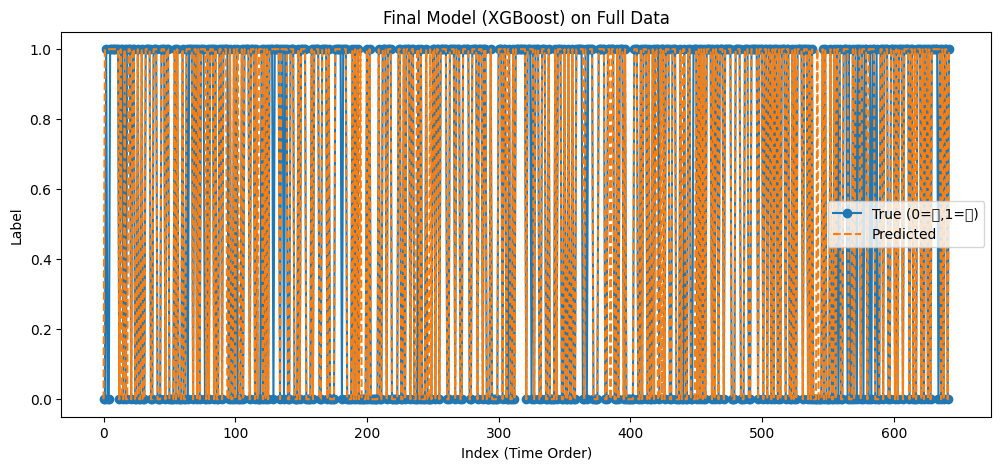

In [14]:
# 輸出 merged_data.csv
df_merged.to_csv("merged_data.csv", index=False)
print("merged_data.csv 已輸出。")

# 視覺化
plt.figure(figsize=(12,5))
plt.plot(range(len(y_full)), y_full, label='True (0=跌,1=漲)', marker='o')
plt.plot(range(len(y_full)), y_pred_final, label='Predicted', linestyle='--')
plt.title(f"Final Model ({best_model_name}) on Full Data")
plt.xlabel("Index (Time Order)")
plt.ylabel("Label")
plt.legend()
plt.show()
